In [ ]:
!gdown --id '1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs' -O 'historical_data.csv'

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/historical_data.csv
100% 47.5M/47.5M [00:00<00:00, 236MB/s]


In [ ]:
!gdown --id '1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf' -O 'fear_greed_index.csv'

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/fear_greed_index.csv
100% 90.8k/90.8k [00:00<00:00, 75.9MB/s]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
market_data=pd.read_csv('/content/fear_greed_index.csv')
historical_data=pd.read_csv('/content/historical_data.csv')

In [ ]:
market_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [ ]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [ ]:
market_data['date']=pd.to_datetime(market_data['date'])
historical_data['Timestamp IST']=pd.to_datetime(historical_data['Timestamp IST'],format="%d-%m-%Y %H:%M")

In [ ]:
historical_data['Trade_Date']=historical_data['Timestamp IST'].dt.date

In [ ]:
daily_trades=historical_data.groupby('Trade_Date').agg(
    total_trades=('Account','count'),
    total_pnl=('Closed PnL', 'sum'),
    avg_trade_size=('Size USD', 'mean'),
    total_fees=('Fee', 'sum'),
    win_trades=('Closed PnL', lambda x: (x > 0).sum()),
    loss_trades=('Closed PnL', lambda x: (x <= 0).sum())
).reset_index()


In [ ]:
daily_trades['win_ratio'] = daily_trades['win_trades'] / (
    daily_trades['win_trades'] + daily_trades['loss_trades']
)

In [ ]:
daily_trades.head()

,Trade_Date,total_trades,total_pnl,avg_trade_size,total_fees,win_trades,loss_trades,win_ratio
0,2023-05-01,3,0.000000,159.000000,0.000000,0,3,0.000000
1,2023-12-05,9,0.000000,5556.203333,12.501455,0,9,0.000000
2,2023-12-14,11,-205.434737,10291.213636,28.300831,4,7,0.363636
3,2023-12-15,2,-24.632034,5304.975000,2.652489,0,2,0.000000
4,2023-12-16,3,0.000000,5116.256667,3.837189,0,3,0.000000


In [ ]:
daily_trades['Trade_Date'] = pd.to_datetime(daily_trades['Trade_Date'])
merged_df = pd.merge(daily_trades, market_data, left_on='Trade_Date', right_on='date')

In [ ]:
merged_df.head()

,Trade_Date,total_trades,total_pnl,avg_trade_size,total_fees,win_trades,loss_trades,win_ratio,timestamp,value,classification,date
0,2023-05-01,3,0.000000,159.000000,0.000000,0,3,0.000000,1682919000,63,Greed,2023-05-01
1,2023-12-05,9,0.000000,5556.203333,12.501455,0,9,0.000000,1701754200,75,Extreme Greed,2023-12-05
2,2023-12-14,11,-205.434737,10291.213636,28.300831,4,7,0.363636,1702531800,72,Greed,2023-12-14
3,2023-12-15,2,-24.632034,5304.975000,2.652489,0,2,0.000000,1702618200,70,Greed,2023-12-15
4,2023-12-16,3,0.000000,5116.256667,3.837189,0,3,0.000000,1702704600,67,Greed,2023-12-16


In [ ]:
correlation_matrix = merged_df[[
    'value', 'total_trades', 'total_pnl', 'avg_trade_size', 'total_fees', 'win_ratio'
]].corr()

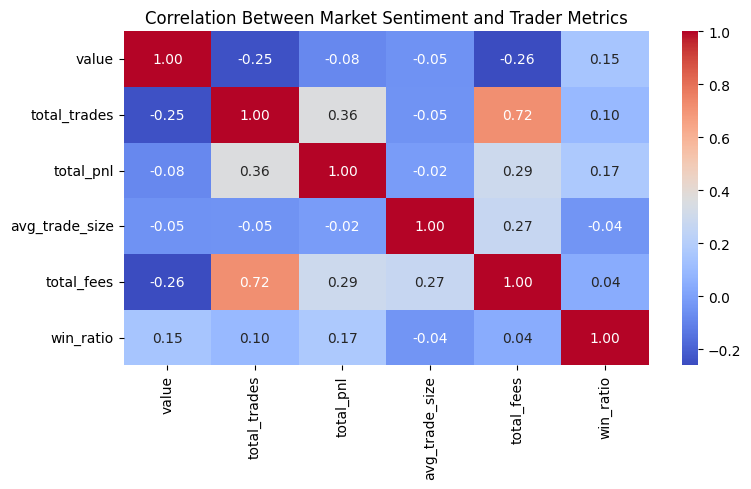

In [ ]:
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Market Sentiment and Trader Metrics")
plt.tight_layout()
plt.show()

/tmp/ipython-input-117-904904826.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x='classification', y='total_pnl', palette='Set2')


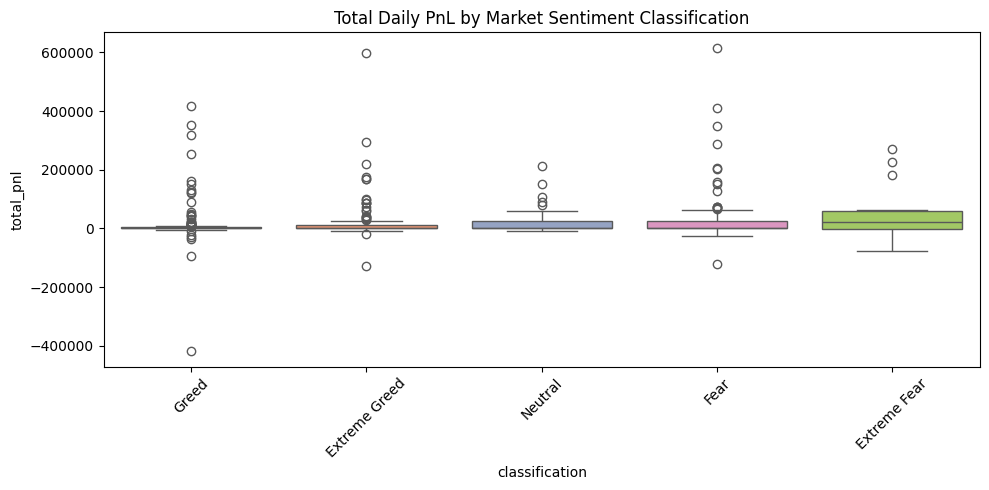

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_df, x='classification', y='total_pnl', palette='Set2')
plt.title("Total Daily PnL by Market Sentiment Classification")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
merged_df['pnl_class'] = (merged_df['total_pnl'] > 0).astype(int)  # 1 = Win, 0 = Loss


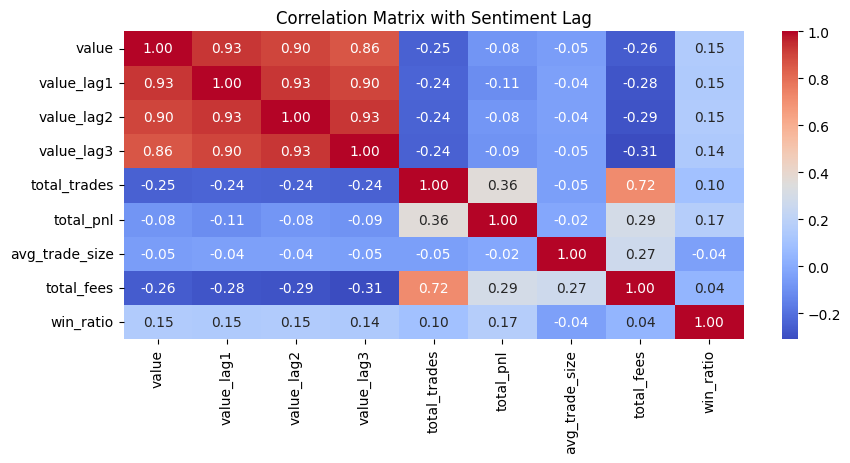

In [ ]:
for lag in range(1, 4):
    merged_df[f'value_lag{lag}'] = merged_df['value'].shift(lag)

lagged_corr = merged_df[[
    'value', 'value_lag1', 'value_lag2', 'value_lag3',
    'total_trades', 'total_pnl', 'avg_trade_size', 'total_fees', 'win_ratio'
]].corr()

plt.figure(figsize=(10, 4))
sns.heatmap(lagged_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix with Sentiment Lag")
plt.show()


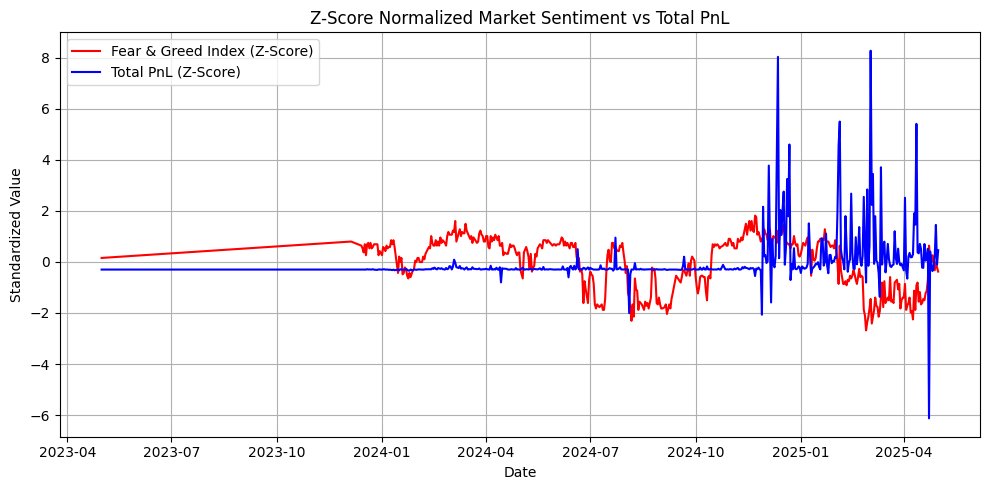

In [ ]:
scaler = StandardScaler()
merged_df[['value_z', 'total_pnl_z']] = scaler.fit_transform(
    merged_df[['value', 'total_pnl']].fillna(0)
)

plt.figure(figsize=(10, 5))
plt.plot(merged_df['date'], merged_df['value_z'], label='Fear & Greed Index (Z-Score)', color='red')
plt.plot(merged_df['date'], merged_df['total_pnl_z'], label='Total PnL (Z-Score)', color='blue')
plt.xlabel("Date")
plt.ylabel("Standardized Value")
plt.title("Z-Score Normalized Market Sentiment vs Total PnL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


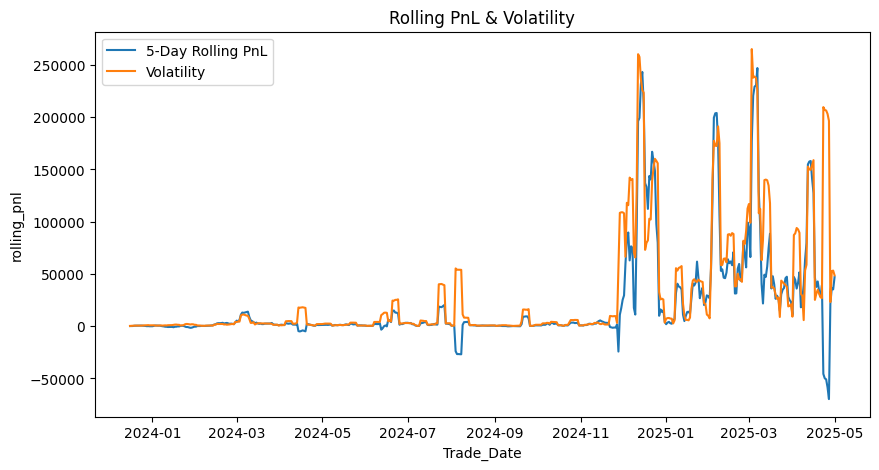

In [ ]:
merged_df['rolling_pnl'] = merged_df['total_pnl'].rolling(window=5).mean()
merged_df['pnl_volatility'] = merged_df['total_pnl'].rolling(window=5).std()

plt.figure(figsize=(10,5))
sns.lineplot(x='Trade_Date', y='rolling_pnl', data=merged_df, label='5-Day Rolling PnL')
sns.lineplot(x='Trade_Date', y='pnl_volatility', data=merged_df, label='Volatility')
plt.legend()
plt.title("Rolling PnL & Volatility")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import numpy as np

features = ['value', 'total_trades', 'avg_trade_size', 'total_fees', 'win_ratio']
X = merged_df[features]
y = merged_df['pnl_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    'RandomForest': (RandomForestClassifier(), {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
        'n_estimators': [100, 200],
        'max_depth': [3, 6]
    }),

    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'C': [0.1, 1, 10]
    })
}

best_models = {}

for name, (model, params) in models.items():
    print(f"\n🔍 Running GridSearchCV for: {name}")
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

    y_pred = grid.predict(X_test)
    print(f"✅ Best Params for {name}: {grid.best_params_}")
    print(classification_report(y_test, y_pred, target_names=['Loss', 'Win']))



🔍 Running GridSearchCV for: RandomForest
✅ Best Params for RandomForest: {'max_depth': None, 'n_estimators': 200}
              precision    recall  f1-score   support

        Loss       0.76      0.53      0.63        30
         Win       0.89      0.96      0.92       114

    accuracy                           0.87       144
   macro avg       0.82      0.74      0.77       144
weighted avg       0.86      0.87      0.86       144


🔍 Running GridSearchCV for: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:26:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Best Params for XGBoost: {'max_depth': 6, 'n_estimators': 200}
              precision    recall  f1-score   support

        Loss       0.67      0.53      0.59        30
         Win       0.88      0.93      0.91       114

    accuracy                           0.85       144
   macro avg       0.77      0.73      0.75       144
weighted avg       0.84      0.85      0.84       144


🔍 Running GridSearchCV for: LogisticRegression
✅ Best Params for LogisticRegression: {'C': 10}
              precision    recall  f1-score   support

        Loss       0.65      0.57      0.61        30
         Win       0.89      0.92      0.91       114

    accuracy                           0.85       144
   macro avg       0.77      0.74      0.76       144
weighted avg       0.84      0.85      0.84       144



In [ ]:
features = ['value', 'total_trades', 'avg_trade_size', 'total_fees', 'win_ratio']
X = merged_df[features]
y = merged_df['pnl_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, max_depth= 10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

label_map = {1: 'Win', 0: 'Loss'}
y_pred_labels = [label_map[i] for i in y_pred]
y_test_labels = [label_map[i] for i in y_test]

print(classification_report(y_test_labels, y_pred_labels))

cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"\n5-Fold Cross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

              precision    recall  f1-score   support

        Loss       0.83      0.50      0.62        30
         Win       0.88      0.97      0.93       114

    accuracy                           0.88       144
   macro avg       0.86      0.74      0.78       144
weighted avg       0.87      0.88      0.86       144


5-Fold Cross-Validation Accuracy: 0.8767 ± 0.0454


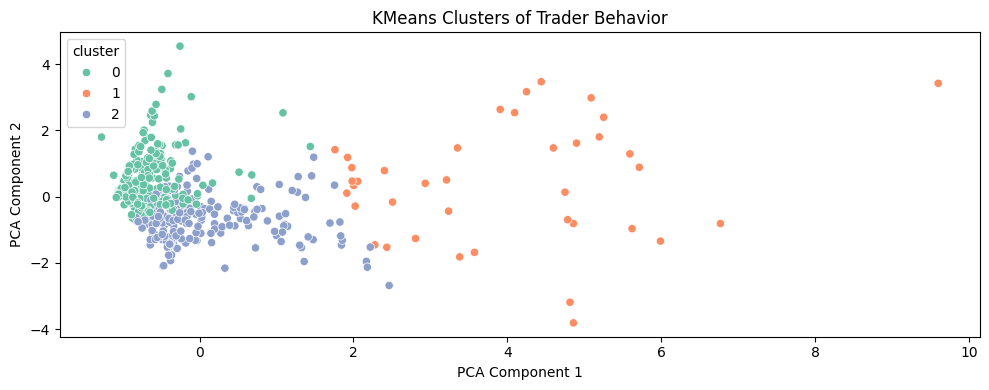

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

features_for_clustering = merged_df[[
    'total_trades', 'total_pnl', 'avg_trade_size', 'total_fees', 'win_ratio'
]].dropna()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

kmeans = KMeans(n_clusters=3, random_state=42)
merged_df['cluster'] = kmeans.fit_predict(scaled_features)

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
merged_df['pca1'] = pca_features[:, 0]
merged_df['pca2'] = pca_features[:, 1]

plt.figure(figsize=(10, 4))
sns.scatterplot(data=merged_df, x='pca1', y='pca2', hue='cluster', palette='Set2')
plt.title("KMeans Clusters of Trader Behavior")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [ ]:
merged_df.to_csv('merged_data.csv', index=False)

In [ ]:
import joblib
model = joblib.dump(model,"model.pkl")

